<a href="https://colab.research.google.com/github/sugi-san/informative-drawings/blob/main/informative_drawings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

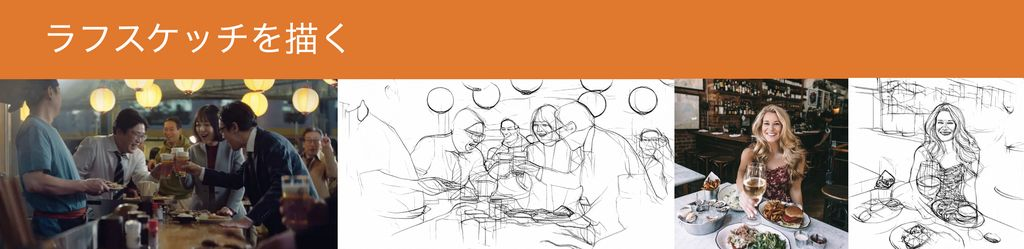

In [ ]:
#@title **1.セットアップ**

# githubからコードを取得
! git clone https://github.com/sugi-san/informative-drawings.git
%cd informative-drawings

# checkpointsフォルダ作成
import os
os.makedirs('checkpoints', exist_ok=True)

# 学習済みパラメータのダウンロード
! pip install --upgrade gdown
import gdown

for i in range(10):
  if os.path.isfile('model.zip'): 
    break
  else:
    gdown.download('https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1', 'model.zip', quiet=False)
! unzip model.zip -d checkpoints

# 関数読み込み
from function import *

# downloadフォルダ作成
import os
os.makedirs('movie/download', exist_ok=True)

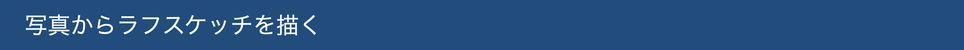

In [ ]:
#@title **2.写真の表示**
display_pic('examples/test')

In [ ]:
#@title **3.写真のスケッチ変換**
! python test.py --name opensketch_style --dataroot examples/test --size 512
display_pic('results/opensketch_style')

In [ ]:
#@title **4.画像のダウンロード**
#@markdown　・zip形式でまとめてダウンロードします
! zip -r data results/opensketch_style

from google.colab import files
files.download('data.zip')

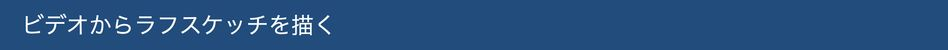

In [ ]:
#@title **5.ビデオの表示**
import os
import glob
print('=== video ===')
reset_folder('movie/pic_video')
files = sorted(glob.glob('movie/video/*.mp4'))
names = []
for file in files:
  name = os.path.basename(file)
  save_frame(name, 'movie/video', 'movie/pic_video')
  names.append(name)
display_movie('movie/pic_video', names)

In [ ]:
#@title **6.ビデオのスケッチ変換**

# --- ビデオを静止画にバラす ---
video = '01.mp4' #@param {type:"string"}
video_file = 'movie/video/'+video
style = 'opensketch_style' 
size =  512

import os
import shutil
import cv2

# 出力フォルダーリセット
reset_folder('movie/images')
 
def video_2_images(video_file= video_file,   # ビデオの指定
                   image_dir='movie/images/', 
                   image_file='%s.jpg'):  

    # Initial setting
    i = 0
    interval = 1
    length = 3000  # 最大フレーム数
    
    cap = cv2.VideoCapture(video_file)
    fps = cap.get(cv2.CAP_PROP_FPS)  # fps取得

    while(cap.isOpened()):
        flag, frame = cap.read()  
        if flag == False:  
                break
        if i == length*interval:
                break
        if i % interval == 0:    
           cv2.imwrite(image_dir+image_file % str(int(i/interval)).zfill(6), frame)
        i += 1 
    cap.release()
    return fps, i, interval
 
fps, i, interval = video_2_images()

print('fps = ', fps)
print('frames = ', i)
print('interval = ', interval)


# --- 静止画をスケッチに変換 ---
# 出力フォルダーリセット
reset_folder('movie/sketch/'+style)

# スケッチ変換
! python test.py --name $style\
                 --dataroot movie/images\
                 --results_dir movie/sketch\
                 --how_many 3000\
                 --size $size


# --- 動画の作成 ---
# 動画の作成
print('makeing movie...')
file_path = 'movie/sketch/'+style+'/%06d_out.png'
! ffmpeg -y -r $fps -i $file_path -vcodec libx264 -pix_fmt yuv420p -loglevel error out.mp4

# 音声の抽出・付加
print('preparation for sound...')
! ffmpeg -y -i $video_file -loglevel error sound.mp3
! ffmpeg -y -i out.mp4 -i sound.mp3 -loglevel error output.mp4

# 動画の再生
print('waiting for play movie...')
display_mp4('output.mp4')

In [ ]:
#@title **7.動画のダウンロード**

import os
import shutil

download_name = 'movie/download/'+os.path.splitext(video)[0]+'_sketch.mp4'
shutil.copy('output.mp4', download_name)

from google.colab import files
files.download(download_name)

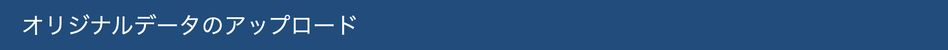

In [ ]:
#@title **8.データのアップロード**
#@markdown ・selectでpicture（.jpg）かvideo（.mp4）を選択して下さい\
#@markdown ・動画はHD以下、20秒以内を目安にして下さい
import os
import shutil
from google.colab import files
import cv2

select = 'video' #@param ["picture", "video"]

# ルートへ画像をアップロード
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
if select == 'picture':
  for file in uploaded:
      if os.path.splitext(file)[1] != '.jpg':
        break
      shutil.move(file, 'examples/test/'+file)
      
if select == 'video':
  for file in uploaded:
      if os.path.splitext(file)[1] != '.mp4':
        break
      shutil.move(file, 'movie/video/'+file)